In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import pyswarm
from autograd import jacobian
import warnings
import random
import copy
import math
import sys

warnings.filterwarnings(action='ignore')

 ## Part 1
 Generate the noisy data (𝑥𝑘 , 𝑦𝑘 ), where 𝑘 = 0, ... ,1000, according to the rule:  
 Approximate the data by the rational function.

In [2]:
x_k = [3 * x / 1000 for x in range(1001)]
y_k = []

for k in range(len(x_k)):
    f_x = 1 / (x_k[k] ** 2  - 3 * x_k[k] + 2)
    if f_x < -100:
        y_k.append(-100 + np.random.normal())
    elif -100 <= f_x <= 100:
        y_k.append(f_x + np.random.normal())
    else:
        y_k.append(100 + np.random.normal())

In [3]:
def rational_func(x, a, b, c, d):
    return (a * x + b) / (x ** 2 + c * x + d)

In [4]:
def mse_func(x):
    sum = 0
    for i in range(1001):
        sum += (rational_func(x_k[i], x[0], x[1], x[2], x[3]) - y_k[i])  ** 2
    
    return sum

In [5]:
def sim_anneal(func):
    return scipy.optimize.basinhopping(func, x0=([0.5, 0.5, 0.5, 0.5]), minimizer_kwargs={'method': 'BFGS'})

def diff_evo(func):
    return scipy.optimize.differential_evolution(func, bounds=[(-2, 2), (-2, 2), (-2, 2), (-2, 2)], tol=0.001)

def neldermead_search(func):
    return scipy.optimize.minimize(func, x0=([0.5, 0.5, 0.5, 0.5]), method='Nelder-Mead', tol=0.001)

def lev_marq_alg(func, x, y):
    return scipy.optimize.curve_fit(func, xdata=x, ydata=y, method='lm')

In [6]:
sa_res = sim_anneal(mse_func).x
de_res = diff_evo(mse_func).x
ns_res = neldermead_search(mse_func).x
lm_res = lev_marq_alg(rational_func, x_k, y_k)[0]

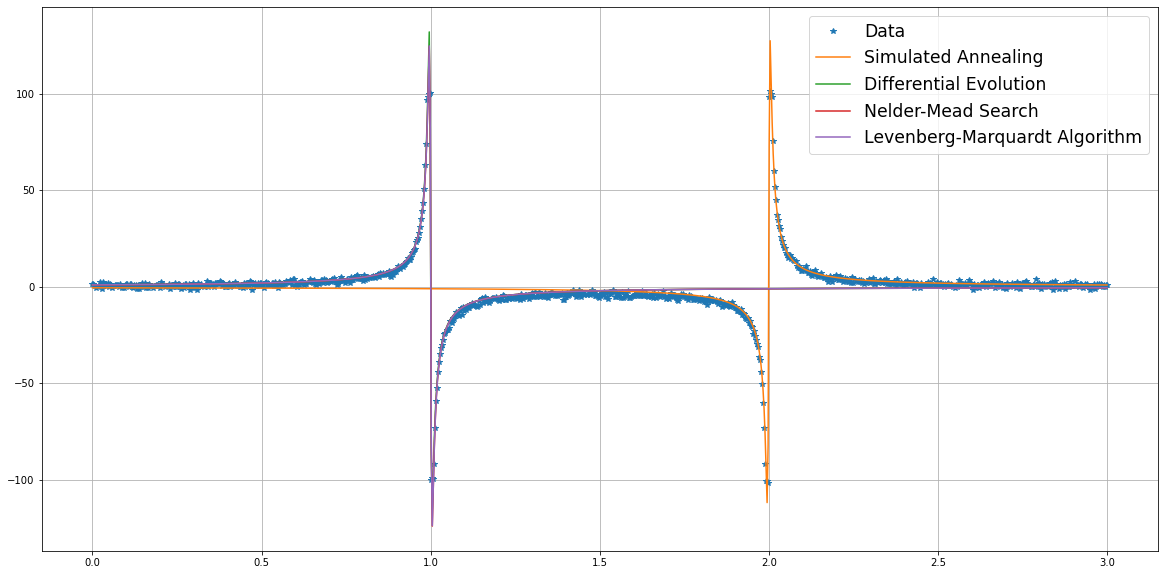

In [7]:
plt.figure(figsize=(20, 10))
plt.plot(x_k, y_k, "*", label='Data')
plt.grid()

y = [rational_func(x, sa_res[0], sa_res[1], sa_res[2], sa_res[3]) for x in x_k]
plt.plot(x_k, y, label='Simulated Annealing')

y = [rational_func(x, de_res[0], de_res[1], de_res[2], de_res[3]) for x in x_k]
plt.plot(x_k, y, label='Differential Evolution')

y = [rational_func(x, ns_res[0], ns_res[1], ns_res[2], ns_res[3]) for x in x_k]
plt.plot(x_k, y, label='Nelder-Mead Search')

y = [rational_func(x, lm_res[0], lm_res[1], lm_res[2], lm_res[3]) for x in x_k]
plt.plot(x_k, y, label='Levenberg-Marquardt Algorithm')

plt.legend(fontsize='xx-large')
plt.savefig('results.png', dpi=300)

In [8]:
def sim_anneal_for_table(func):
    sa = scipy.optimize.basinhopping(func, x0=([0.5, 0.5, 0.5, 0.5]), minimizer_kwargs={'method': 'BFGS'})
    return sa.nit, sa.nfev, sa.x[0], sa.x[1], sa.x[2], sa.x[3]

def diff_evo_for_table(func):
    de = scipy.optimize.differential_evolution(func, bounds=[(-2, 2), (-2, 2), (-2, 2), (-2, 2)], tol=0.001)
    return de.nit, de.nfev, de.x[0], de.x[1], de.x[2], de.x[3]
     
def neldermead_search_for_table(func):
    ns = scipy.optimize.minimize(func, x0=([0.5, 0.5, 0.5, 0.5]), method='Nelder-Mead', tol=0.001)
    return ns.nit, ns.nfev, ns.x[0], ns.x[1], ns.x[2], ns.x[3]

def lev_marq_alg_for_table(func, x, y):
    lma = scipy.optimize.curve_fit(func, xdata=x, ydata=y, method='lm')
    popt, pcov, infodict, errmsg, ier = scipy.optimize.curve_fit(func, xdata=x, ydata=y, method='lm', full_output=True)
    lma_1 = infodict
    return lma_1['nfev'], lma[0][0], lma[0][1], lma[0][2], lma[0][3]

In [9]:
results_table = pd.DataFrame(columns=['method', 'num_of_iterations',
                                      'num_of_f(x)_calculations', 'a', 'b', 'c', 'd'])

In [10]:
num_iter_sa, num_f_culc_sa, culc_a_sa, culc_b_sa, culc_d_sa, culc_c_sa = sim_anneal_for_table(mse_func)
num_iter_de, num_f_culc_de, culc_a_de, culc_b_de, culc_d_de, culc_c_de = diff_evo_for_table(mse_func)
num_iter_ns, num_f_culc_ns, culc_a_ns, culc_b_ns, culc_d_ns, culc_c_ns = neldermead_search_for_table(mse_func)
num_f_culc_lma, culc_a_lma, culc_b_lma, culc_d_lma, culc_c_lma = lev_marq_alg_for_table(rational_func, x_k, y_k)


results_table = results_table.append({'method' : 'Simulated Annealing', 'num_of_iterations': num_iter_sa,
                    'num_of_f(x)_calculations': num_f_culc_sa, 
                    'a' : culc_a_sa, 'b' : culc_b_sa,
                    'd' : culc_d_sa, 'c' : culc_c_sa}, ignore_index=True)

results_table = results_table.append({'method' : 'Differential Evolution', 'num_of_iterations': num_iter_de,
                    'num_of_f(x)_calculations': num_f_culc_de,  
                    'a' : culc_a_de, 'b' : culc_b_de,
                    'd' : culc_d_de, 'c' : culc_c_de}, ignore_index=True)

results_table = results_table.append({'method' : 'Nelder-Mead algorithm', 'num_of_iterations': num_iter_ns,
                    'num_of_f(x)_calculations': num_f_culc_ns,  
                    'a' : culc_a_ns, 'b' : culc_b_ns,
                    'd' : culc_d_ns, 'c' : culc_c_ns}, ignore_index=True)

results_table = results_table.append({'method' : 'Levenberg- Marquardt algorithm', 'num_of_iterations': num_f_culc_lma // 2,
                    'num_of_f(x)_calculations': num_f_culc_lma,  
                    'a' : culc_a_lma, 'b' : culc_b_lma,
                    'd' : culc_d_lma, 'c' : culc_c_lma}, ignore_index=True)

results_table

,method,num_of_iterations,num_of_f(x)_calculations,a,b,c,d
0,Simulated Annealing,100,66142,0.998921,-1.997401,3.998406,-3.999195
1,Differential Evolution,141,8615,-0.992044,0.992307,1.000016,-2.0
2,Nelder-Mead algorithm,301,511,-0.99591,0.996406,1.000995,-2.000979
3,Levenberg- Marquardt algorithm,108,216,-0.998809,0.999298,1.000959,-2.000943


## Part 2 
Solve the corresponding Travelling Salesman Problem using the Simulated Annealing method.

In [11]:
cities = pd.read_table('128_cities.txt',sep=' ')
cities_tuple = list(cities.itertuples(index=False, name=None))

temperature: 500.000, length: 82309.62


<Figure size 432x288 with 0 Axes>

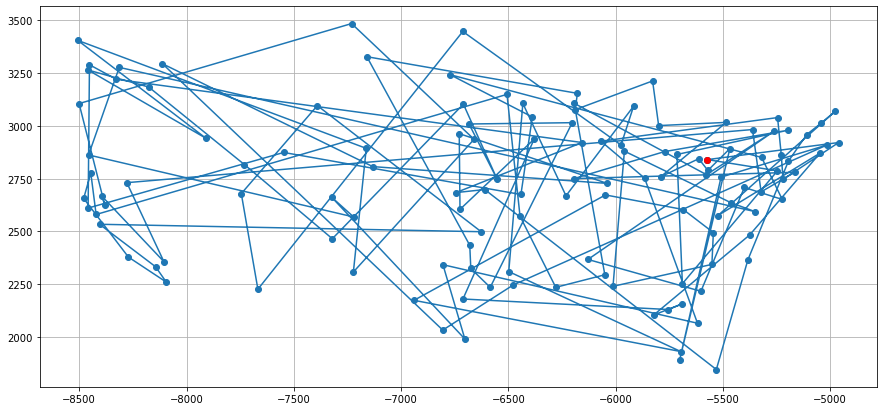

temperature: 399.033, length: 61089.02
temperature: 299.864, length: 49393.62
temperature: 200.803, length: 39293.31
temperature: 100.041, length: 24849.00
temperature: 50.092, length: 20339.49
temperature: 10.022, length: 17821.88
temperature: 5.018, length: 17821.88
temperature: 1.004, length: 17821.88
temperature: 0.099, length: 17821.88


<Figure size 432x288 with 0 Axes>

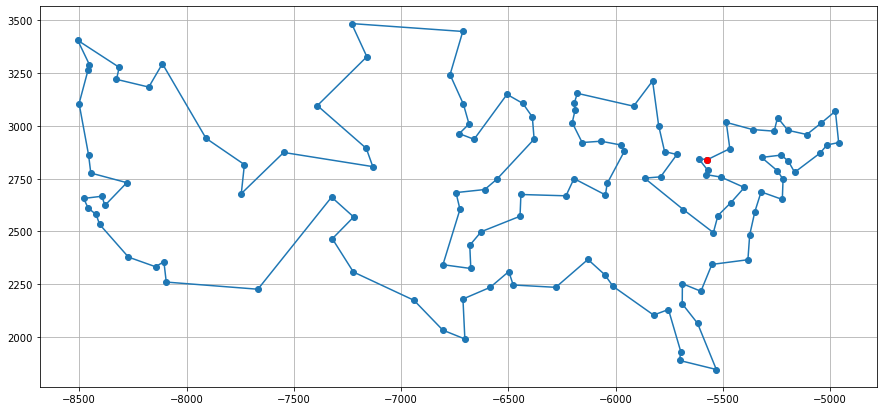

Best route:  [0, 27, 47, 116, 55, 23, 36, 81, 111, 106, 3, 66, 25, 45, 58, 79, 11, 126, 9, 97, 26, 119, 113, 8, 57, 82, 56, 19, 108, 16, 84, 52, 35, 53, 76, 40, 41, 32, 72, 50, 38, 29, 31, 94, 95, 112, 86, 44, 100, 43, 92, 93, 88, 87, 98, 89, 90, 85, 110, 59, 123, 125, 18, 101, 54, 78, 33, 17, 2, 28, 68, 39, 96, 121, 114, 62, 80, 74, 10, 124, 6, 34, 22, 70, 1, 71, 107, 102, 117, 24, 104, 48, 99, 14, 13, 73, 75, 42, 65, 77, 103, 67, 30, 51, 69, 105, 21, 115, 4, 60, 20, 122, 46, 83, 109, 49, 91, 64, 120, 12, 5, 118, 63, 7, 37, 15, 61, 127, 0]


<Figure size 432x288 with 0 Axes>

In [12]:
t_start = 500   # start temperature
t_end = 0.099   # end temperature
steps = 1000    # steps at given temperature
alpha = 0.995   # temperature reduction coefficient
n = 128         # numbers of cities

class Solution:
    def __init__(self):
        self.plan = list(range(n))
        self.plan.append(0)
        self.mutate()
        self.fitness = sys.maxsize

    def mutate(self):
        subpath_start = random.randrange(1, n-1)
        subpath_end = random.randrange(subpath_start+2, n+1)
        plan_copy = self.plan[subpath_start:subpath_end]
        plan_copy = plan_copy[::-1]
        self.plan[subpath_start:subpath_end] = plan_copy

    def calc_fitness(self):
        self.fitness = sum([distance_matrix[self.plan[i]][self.plan[i + 1]] for i in range(n)])

def plot():
    x_values = [coords[best.plan[i]][0] for i in range(n + 1)]
    y_values = [coords[best.plan[i]][1] for i in range(n + 1)]
    plt.clf()
    plt.figure(figsize=(15, 7))
    plt.plot(x_values, y_values, 'o-')
    plt.plot(x_values[0], y_values[0], 'ro')
    plt.grid()
    plt.show()

def save_plot():
    x_values = [coords[best.plan[i]][0] for i in range(n + 1)]
    y_values = [coords[best.plan[i]][1] for i in range(n + 1)]
    plt.clf()
    plt.figure(figsize=(15, 7))
    plt.plot(x_values, y_values, 'o-')
    plt.plot(x_values[0], y_values[0], 'ro')
    plt.grid()
    plt.savefig(name_for_plot, dpi=300)
    plt.close()



coords = cities_tuple 

distance_matrix = [[_ for _ in range(n)] for _ in range(n)]
for row in range(n):
    for col in range(n):
        distance_matrix[row][col] = math.sqrt(sum((coords[row][i] - coords[col][i]) ** 2 for i in range(2)))

current = Solution()
current.calc_fitness()
working = copy.deepcopy(current)
best = copy.deepcopy(current)
t = t_start

name_for_plot = 'first_itetation'


while t > t_end:
    for _ in range(steps):
        f_new = False
        working.mutate()
        working.calc_fitness()
        if working.fitness <= current.fitness:
            f_new = True
        else:
            delta = working.fitness - current.fitness
            p = math.exp(-delta / t)
            if p > random.random():
                f_new = True
        if f_new:
            current = copy.deepcopy(working)
            if current.fitness < best.fitness:
                best = copy.deepcopy(current)
        else:
            working = copy.deepcopy(current)
            
    if (t <= 501.00 and t >= 499.50 or t <= 400.00 and t >= 399.00 or
    t <= 300.00 and t >= 299.50 or t <= 201.00 and t >= 200.00 or
    t <= 100.10 and t >= 100.00 or t <= 50.10 and t >= 50.00 or
    t <= 10.03 and t >= 10.00 or t <= 5.02 and t>= 5.00 or
    t <= 1.005 and t>= 1.00 or t <= 0.0992 and t>= 0.0990): 
        print('temperature: {:5.3f}, length: {:5.2f}'.format(t, best.fitness))
       
    if t <= 501.00 and t >= 499.50 or t <= 0.0992 and t>= 0.0990:
        plot()
        
    if t == 500.00 or t <= 0.0992 and t>= 0.0990: 
        save_plot()
        name_for_plot = 'last_itetation'
        
    t *= alpha
    
print("Best route: ", best.plan)